Training Head & Shoulders CNN detector...
epoch=1 loss=0.6917 test_acc=0.4878
epoch=2 loss=0.6420 test_acc=0.9633
epoch=3 loss=0.4556 test_acc=0.9056
epoch=4 loss=0.3314 test_acc=0.9278
epoch=5 loss=0.1818 test_acc=0.9444
epoch=6 loss=0.1580 test_acc=0.9644
epoch=7 loss=0.1540 test_acc=0.9722
epoch=8 loss=0.1285 test_acc=0.9656

--- Running live simulation with H&S pattern injection ---

bar= 100 price=0.9748 p_hs=0.019 consecutive=0 gate=1.00 alloc=1.00 
bar= 150 price=0.9937 p_hs=0.096 consecutive=0 gate=1.00 alloc=1.00 
bar= 157 price=0.9663 p_hs=0.676 consecutive=1 gate=0.32 alloc=0.32 *** H&S DETECTED ***
bar= 158 price=0.9445 p_hs=0.750 consecutive=2 gate=0.25 alloc=0.25 *** H&S DETECTED ***
bar= 159 price=0.9570 p_hs=0.817 consecutive=3 gate=0.18 alloc=0.18 *** H&S DETECTED ***
bar= 160 price=0.9469 p_hs=0.859 consecutive=4 gate=0.14 alloc=0.14 *** H&S DETECTED ***
bar= 161 price=0.9537 p_hs=0.896 consecutive=5 gate=0.10 alloc=0.10 *** H&S DETECTED ***
bar= 162 price=0.9448 p_hs

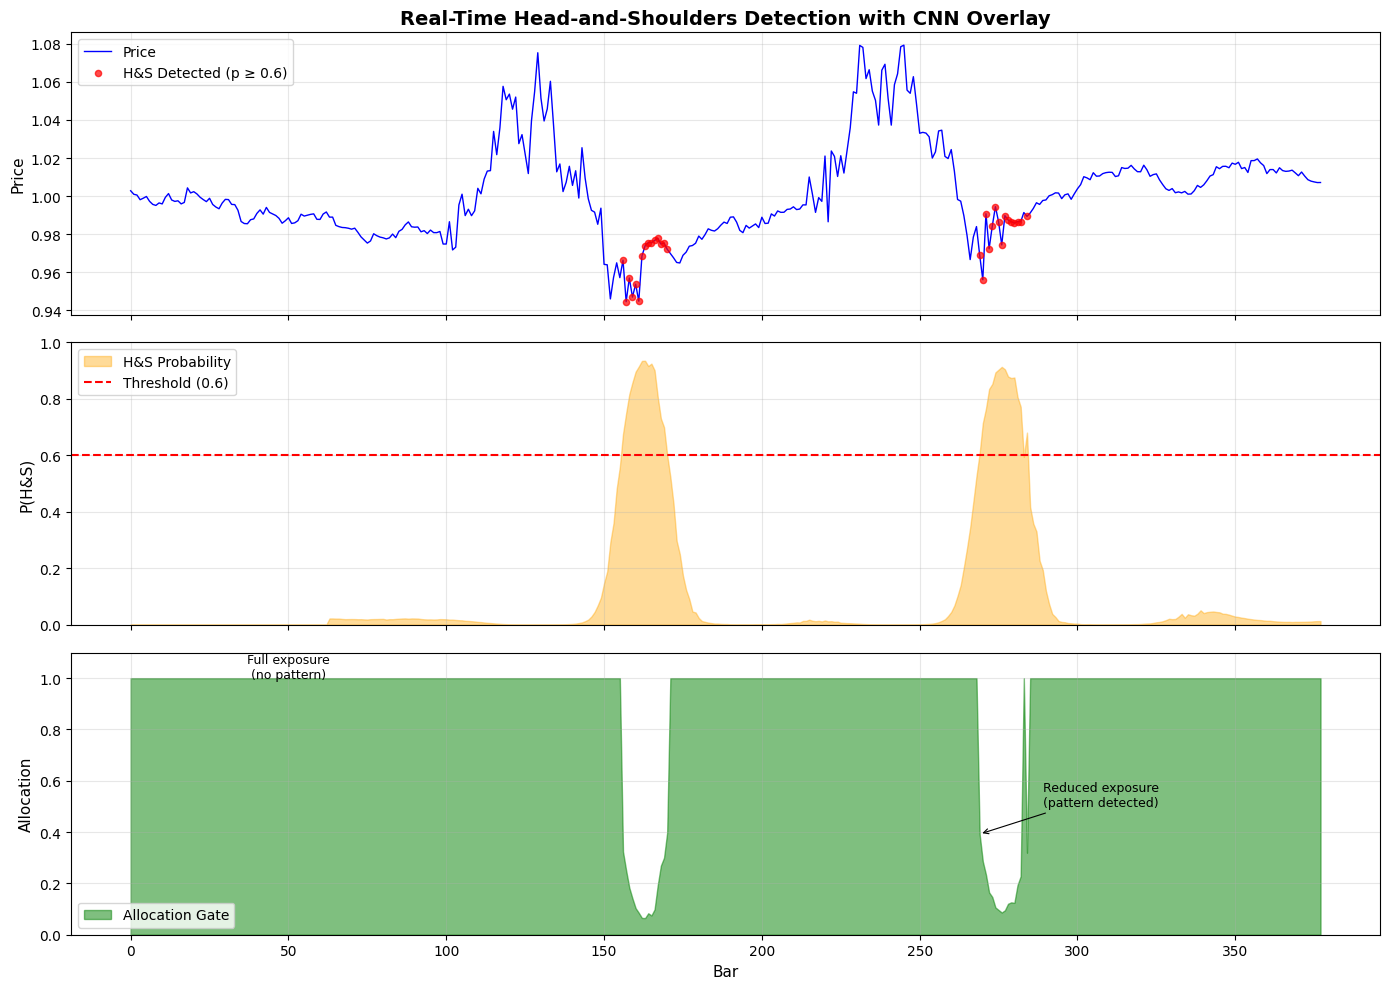

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import yfinance as yf


# -----------------------------
# 1) Synthetic data generation
# -----------------------------
def gen_head_and_shoulders(window=64, noise_std=0.01, amp=0.08, seed=None):
    """
    Generate a synthetic Head-and-Shoulders top pattern.
    Output: normalized 1D price series length=window.
    """
    if seed is not None:
        np.random.seed(seed)

    x = np.linspace(0, 1, window)

    # Define three peaks: left shoulder, head, right shoulder
    # Use Gaussian bumps for smoothness
    def bump(center, width, height):
        return height * np.exp(-0.5 * ((x - center) / width) ** 2)

    baseline = 1.0 + 0.02 * np.sin(2 * np.pi * x)  # mild waviness
    left = bump(center=0.30, width=0.06, height=amp * 0.7)
    head = bump(center=0.50, width=0.07, height=amp * 1.0)
    right = bump(center=0.70, width=0.06, height=amp * 0.7)

    # Add a gentle down drift after the head (to hint reversal)
    drift = -0.03 * np.clip(x - 0.55, 0, 1)

    y = baseline + left + head + right + drift
    y += np.random.normal(0, noise_std, size=window)

    # Normalize to start at 1.0 (scale invariance)
    y = y / y[0]
    return y.astype(np.float32)


def gen_non_pattern(window=64, noise_std=0.01, seed=None):
    """
    Generate a synthetic non-pattern series (random walk + drift + noise).
    """
    if seed is not None:
        np.random.seed(seed)

    steps = np.random.normal(0, noise_std, size=window)
    drift = np.linspace(0, np.random.uniform(-0.01, 0.01), window)
    y = 1.0 + np.cumsum(steps) + drift
    y = y / y[0]
    return y.astype(np.float32)


def build_dataset(n=5000, window=64, pos_frac=0.5):
    n_pos = int(n * pos_frac)
    n_neg = n - n_pos

    X = []
    y = []

    for i in range(n_pos):
        X.append(gen_head_and_shoulders(window=window, seed=i))
        y.append(1)

    for i in range(n_neg):
        X.append(gen_non_pattern(window=window, seed=10_000 + i))
        y.append(0)

    X = np.stack(X, axis=0)  # (N, window)
    y = np.array(y, dtype=np.float32)  # (N,)
    # Shuffle
    idx = np.random.permutation(len(y))
    return X[idx], y[idx]


# -----------------------------
# 2) CNN model
# -----------------------------
class HSCNN(nn.Module):
    def __init__(self, window=64):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, padding=3)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.pool = nn.MaxPool1d(kernel_size=2)

        # After 2 pools, length halves twice: window -> window/2 -> window/4
        flat_len = 32 * (window // 4)
        self.fc1 = nn.Linear(flat_len, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x


# -----------------------------
# 3) Train
# -----------------------------
def train_model(window=64, epochs=8, batch_size=128, lr=1e-3, device="cpu"):
    X, y = build_dataset(n=6000, window=window, pos_frac=0.5)

    # Train/test split
    split = int(0.85 * len(y))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    X_train = torch.tensor(X_train).view(-1, 1, window).to(device)
    y_train = torch.tensor(y_train).view(-1, 1).to(device)

    X_test = torch.tensor(X_test).view(-1, 1, window).to(device)
    y_test = torch.tensor(y_test).view(-1, 1).to(device)

    model = HSCNN(window=window).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss()

    for ep in range(1, epochs + 1):
        model.train()
        perm = torch.randperm(X_train.size(0))
        X_train_shuf = X_train[perm]
        y_train_shuf = y_train[perm]

        for i in range(0, X_train.size(0), batch_size):
            xb = X_train_shuf[i : i + batch_size]
            yb = y_train_shuf[i : i + batch_size]

            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()

        # Evaluate
        model.eval()
        with torch.no_grad():
            pred = model(X_test)
            acc = ((pred > 0.5) == (y_test > 0.5)).float().mean().item()
            print(f"epoch={ep} loss={loss.item():.4f} test_acc={acc:.4f}")

    return model


# -----------------------------
# 4) Streaming inference + overlay
# -----------------------------
def overlay_gate(p_hs, lo=0.0, hi=1.0):
    """
    Simple gating rule: reduce exposure as pattern probability rises.
    """
    gate = 1.0 - float(p_hs)
    return max(lo, min(hi, gate))


def live_price_stream():
    """
    Stub generator. Replace with real bars.
    Here: generate a time series where a H&S pattern occasionally appears.
    """
    # start with random walk
    p = 1.0
    for t in range(100):
        p *= 1.0 + np.random.normal(0, 0.002)
        yield float(p)

    # insert a synthetic head-and-shoulders formation using SAME parameters as training
    # Use window=64 and same amp/noise as training for reliable detection
    hs = gen_head_and_shoulders(window=64, noise_std=0.01, amp=0.08)
    base = p
    for v in hs:
        yield float(base * v)

    # short gap then another H&S pattern
    p = base * hs[-1]
    for t in range(50):
        p *= 1.0 + np.random.normal(0, 0.002)
        yield float(p)

    # second H&S pattern
    hs2 = gen_head_and_shoulders(window=64, noise_std=0.01, amp=0.08, seed=999)
    base = p
    for v in hs2:
        yield float(base * v)

    # continue random walk
    p = base * hs2[-1]
    for t in range(100):
        p *= 1.0 + np.random.normal(0, 0.002)
        yield float(p)


def run_live(model, window=64, threshold=0.60, device="cpu"):
    """
    Run live inference with lower threshold and immediate gating for demonstration.
    Returns data for visualization.
    """
    model.eval()

    buf = []
    base_allocation = 1.0  # imagine your main strategy wants to be 100% long

    # optional persistence: require consecutive hits
    consecutive = 0
    need_k = 2  # reduced from 3 for faster response

    bar_num = 0
    detected_count = 0

    # Collect data for visualization
    prices = []
    probabilities = []
    allocations = []
    detection_bars = []

    for px in live_price_stream():
        buf.append(px)
        bar_num += 1
        prices.append(px)

        if len(buf) < window:
            probabilities.append(0.0)
            allocations.append(1.0)
            continue

        w = np.array(buf[-window:], dtype=np.float32)
        w = w / w[0]  # normalize

        inp = torch.tensor(w).view(1, 1, window).to(device)

        with torch.no_grad():
            p_hs = model(inp).item()

        probabilities.append(p_hs)

        if p_hs >= threshold:
            consecutive += 1
        else:
            consecutive = 0

        # Apply overlay if pattern detected (even on first detection for visibility)
        if p_hs >= threshold:
            gate = overlay_gate(p_hs)
            detected_count += 1
            detection_bars.append(bar_num - 1)  # 0-indexed for plotting
        else:
            gate = 1.0

        allocations.append(gate)
        final_allocation = base_allocation * gate

        # Only print when something interesting happens (pattern detected or every 20 bars)
        if p_hs >= threshold or bar_num % 50 == 0:
            status = "*** H&S DETECTED ***" if p_hs >= threshold else ""
            print(
                f"bar={bar_num:4d} price={px:.4f} p_hs={p_hs:.3f} consecutive={consecutive} "
                f"gate={gate:.2f} alloc={final_allocation:.2f} {status}"
            )

    print(
        f"\n=== Summary: {detected_count} bars with H&S pattern detection (p >= {threshold}) ==="
    )

    return {
        "prices": np.array(prices),
        "probabilities": np.array(probabilities),
        "allocations": np.array(allocations),
        "detection_bars": detection_bars,
        "threshold": threshold,
    }


def plot_detection_results(results, save_path=None):
    """
    Visualize price series with H&S pattern detections highlighted.
    """
    prices = results["prices"]
    probs = results["probabilities"]
    allocs = results["allocations"]
    detections = results["detection_bars"]
    threshold = results["threshold"]

    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    bars = np.arange(len(prices))

    # --- Panel 1: Price with detection highlighting ---
    ax1 = axes[0]
    ax1.plot(bars, prices, "b-", linewidth=1, label="Price")

    # Highlight detection regions
    if detections:
        detection_prices = prices[detections]
        ax1.scatter(
            detections,
            detection_prices,
            c="red",
            s=20,
            alpha=0.7,
            label=f"H&S Detected (p ≥ {threshold})",
            zorder=5,
        )

    ax1.set_ylabel("Price", fontsize=11)
    ax1.set_title(
        "Real-Time Head-and-Shoulders Detection with CNN Overlay",
        fontsize=14,
        fontweight="bold",
    )
    ax1.legend(loc="upper left")
    ax1.grid(True, alpha=0.3)

    # --- Panel 2: Detection probability ---
    ax2 = axes[1]
    ax2.fill_between(bars, 0, probs, alpha=0.4, color="orange", label="H&S Probability")
    ax2.axhline(
        y=threshold,
        color="red",
        linestyle="--",
        linewidth=1.5,
        label=f"Threshold ({threshold})",
    )
    ax2.set_ylabel("P(H&S)", fontsize=11)
    ax2.set_ylim(0, 1)
    ax2.legend(loc="upper left")
    ax2.grid(True, alpha=0.3)

    # --- Panel 3: Allocation gate ---
    ax3 = axes[2]
    ax3.fill_between(bars, 0, allocs, alpha=0.5, color="green", label="Allocation Gate")
    ax3.set_ylabel("Allocation", fontsize=11)
    ax3.set_xlabel("Bar", fontsize=11)
    ax3.set_ylim(0, 1.1)
    ax3.legend(loc="lower left")
    ax3.grid(True, alpha=0.3)

    # Add annotations for key events
    ax3.annotate("Full exposure\n(no pattern)", xy=(50, 1.0), fontsize=9, ha="center")
    if detections:
        mid_detect = detections[len(detections) // 2]
        ax3.annotate(
            "Reduced exposure\n(pattern detected)",
            xy=(mid_detect, allocs[mid_detect]),
            xytext=(mid_detect + 20, 0.5),
            fontsize=9,
            ha="left",
            arrowprops=dict(arrowstyle="->", color="black", lw=0.8),
        )

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"\nChart saved to: {save_path}")

    plt.show()
    return fig


if __name__ == "__main__":
    device = "cpu"
    window = 64
    print("Training Head & Shoulders CNN detector...")
    model = train_model(
        window=window, epochs=8, device=device
    )  # more epochs for better accuracy
    print("\n--- Running live simulation with H&S pattern injection ---\n")
    results = run_live(model, window=window, threshold=0.60, device=device)

    # Generate visualization
    print("\nGenerating visualization...")
    plot_detection_results(results, save_path="hs_detection_chart.png")